# Replicating the Product Space Network using International Trade Data (Hidalgo, 2007)

The purpose of this seminar is to demonstrate a few ``Python`` ecosystem tools that enable **research** in areas that can be very difficult to do in traditional tools such as ``Stata``. It also demonstrates how diverse the ``Python`` ecosystem is and the type of analysis that is possible. 

Here we focus on an application of network analysis that is applied to a ``medium`` sized dataset to replicate some of the results contained in the Hidalgo (2007) paper and later in the [The Atlas of Complexity](http://atlas.cid.harvard.edu/) and [The Observatory of Economic Complexity](http://atlas.media.mit.edu/en/).

![Product Space](./img/atlas_productspace.png)

The Hidalogo (2007) paper is used as a **motivating example** to demonstrate various tools that are available in the ``Python`` ecosystem. 

The **tasks** involve using product level international export data to:

1. Compute Revealed Comparative Advantage and $M_{cp}$ matrices [**Tools: Pandas**]
1. Compute Proximity Matrices ($\phi_{pp'}$) and make this code run fast [**Tools: Pandas, Numpy, Numba, Dask**]
1. Building Networks and Plotting Product Space Network Diagrams - albiet not as fancy [**Tools: NetworkX**]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import networkx as nx
from bokeh.io import output_notebook

In [2]:
#-Load Jupyter Extensions-#
%matplotlib inline
output_notebook()

Loading BokehJS ...

## Data

International Trade Data is largely available in SITC and HS product classification systems. 

In this notebook we will focus on SITC revision 2 Level 4 data with ``786`` defined products. 

|Classification | Level | Products |
|---------------|-------|----------|
|SITC           | 4     | 786      |
|HS             | 6     | 5016     |

**Note:** 

We use ``SITC`` data in this seminar, but as you can see performance of code becomes even more important when working with fully disaggregated ``HS`` international trade data

In [3]:
fl = "./data/year_origin_sitc_rev2.csv"
data = pd.read_csv(fl, converters={'sitc':str})   #Import SITC codes as strings to preserve formatting

In [4]:
data.head()

year origin  sitc   export
0  1962    AFG  0230   4000.0
1  1962    AFG  0250  66000.0
2  1962    AFG  0540  74000.0
3  1962    AFG  0545  17000.0
4  1962    AFG  0548  33000.0

### Exercise 1: What years are available in this dataset?

**Hint:** There is a method named ``unique()``, so you should get the array of years and then call ``.unique()``

<button data-toggle="collapse" data-target="#sol1" class='btn btn-primary'>Solution</button>
<div id="sol1" class="collapse">
```python
data['year'].unique()
```

### Exercise 2: How many non-zero trade flow values are in this dataset?

<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>Solution</button>
<div id="sol2" class="collapse">
```python
data.shape[0]
```

### Exercise 3: What countries are available in this dataset?

<button data-toggle="collapse" data-target="#sol3" class='btn btn-primary'>Solution</button>
<div id="sol3" class="collapse">
```python
data['origin'].unique()
```

In [5]:
data[(data['year'] == 2000)&(data['origin']=="AUS")].head()

year origin  sitc       export
2213361  2000    AUS  0011  260132101.0
2213362  2000    AUS  0012  167611315.0
2213363  2000    AUS  0013     280098.0
2213364  2000    AUS  0014     548603.0
2213365  2000    AUS  0015  134571371.0

In [6]:
data[data['origin'] == 'AUS'].set_index(["year","sitc"])["export"].unstack(level="year").head()

year       1962       1963       1964       1965       1966       1967  \
sitc                                                                     
0010        NaN        NaN        NaN     1000.0        NaN        NaN   
0011  1286000.0   675000.0  1177000.0  1700000.0   748000.0   548000.0   
0012  2600000.0  3619000.0  5593000.0  3560000.0  4725000.0  5078000.0   
0013    26000.0    52000.0    81000.0    69000.0    60000.0    32000.0   
0014   375000.0   398000.0   445000.0   187000.0    83000.0    73000.0   

year       1968       1969        1970        1971      ...              2005  \
sitc                                                    ...                     
0010        NaN     1000.0         NaN         NaN      ...               NaN   
0011   586000.0   747000.0    331000.0    443000.0      ...       283381176.0   
0012  5578000.0  6828000.0  11517000.0  13321000.0      ...       211748259.0   
0013    99000.0   108000.0    108000.0    189000.0      ...          260620.0   
0014    30000.0    83000.0    263000.0    258000.0      ...          592790.0   

year         2006         2007         2008         2009         2010  \
sitc                                                                    
0010          NaN          NaN          NaN          NaN          NaN   
0011  284544151.0  365401097.0  571444736.0  586230117.0  793934945.0   
0012  215548475.0  216467212.0  307677017.0  296862273.0  319842757.0   
0013     309274.0     549802.0     153458.0      37764.0     224888.0   
0014    2842029.0    3599939.0    4708910.0    6542608.0    5466152.0   

year         2011         2012         2013          2014  
sitc                                                       
0010          NaN          NaN          NaN           NaN  
0011  650001457.0  627274883.0  728998394.0  1.114734e+09  
0012  347639153.0  296233596.0  174194459.0  2.209887e+08  
0013          NaN          NaN     345256.0  2.302240e+05  
0014    5372783.0    4237839.0    1165708.0  3.056300e+05  

[5 rows x 53 columns]

---------------

## Computing Revealed Comparative Advantage

The literature uses the standard Balassa definition for Revealed Comparative Advantage

$$
\large
RCA_{cpt} = \frac{\frac{E_{cpt}}{E_{ct}}}{\frac{E_{pt}}{E_t}}
$$

where,

1. $E_{cpt}$ are exports from country $c$ in product $p$ at time $t$
1. $E_{ct}$ are total country $c$ exports at time $t$
1. $E_{pt}$ are total product $p$ exports at time $t$
1. $E_{t}$ are total world exports at time $t$

**Reference:** Balassa, B. (1965), Trade Liberalisation and Revealed Comparative Advantage, The Manchester School, 33, 99-123.

To compute **RCA** we need to aggregate data at difference levels to obtain each component of the fraction defined above. 

Let's break the equation down to figure out what needs to be computed:

$$
\large
E_{ct} = \sum_{ct}{E_{cpt}}
$$

In [6]:
cntry_export = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).sum()
cntry_export.head(n=2)

export
year origin             
1962 AFG      86135000.0
     AGO     119458000.0

This gives us a ``pandas.DataFrame`` that is indexed by a multi-index object. This can be very useful but we would like to use this data in the original data table for each product exported at time t by each country. We could use this new object and:

1. ``merge`` the data back into the original data DataFrame
2. use ``transform`` to request an object that is of the same shape as the original data DataFrame. 

In [7]:
data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum).head(n=2)

export
0  86135000.0
1  86135000.0

In [8]:
#-This can be added to the initial data table as a column-#
data["cntry_export"] = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum)

In [9]:
#-We have now added the same value for each product exported by AFG in 1962
data.head(n=2)

year origin  sitc   export  cntry_export
0  1962    AFG  0230   4000.0    86135000.0
1  1962    AFG  0250  66000.0    86135000.0

### Exercise 4: Compute total Product Export for each year in the dataset

$$
\large
E_{pt} = \sum_{pt}{E_{cpt}}
$$

In [10]:
data["prod_export"] = data[["year", "sitc", "export"]].groupby(by=["year", "sitc"]).transform(np.sum)

<button data-toggle="collapse" data-target="#sol4" class='btn btn-primary'>Solution</button>
<div id="sol4" class="collapse">
```python
data["prod_export"] = data[["year", "sitc", "export"]].groupby(by=["year", "sitc"]).transform(np.sum)
```

### Exercise 5: Compute total World Export for each year in the dataset

$$
\large
E_{t} = \sum_{t}{E_{cpt}}
$$

In [11]:
data["world_export"] = data[["year", "export"]].groupby(by=["year"]).transform(np.sum)

<button data-toggle="collapse" data-target="#sol5" class='btn btn-primary'>Solution</button>
<div id="sol5" class="collapse">
```python
data["world_export"] = data[["year", "export"]].groupby(by=["year"]).transform(np.sum)
```

Now that the components of the equation have been computed we can now simply calculate $RCA$ as expressed by the original fraction

In [12]:
data["rca"] = (data["export"] / data["cntry_export"]) / (data["prod_export"] / data["world_export"])

In [13]:
data.head()

year origin  sitc   export  cntry_export  prod_export  world_export  \
0  1962    AFG  0230   4000.0    86135000.0  438581000.0  1.428420e+11   
1  1962    AFG  0250  66000.0    86135000.0  261448000.0  1.428420e+11   
2  1962    AFG  0540  74000.0    86135000.0   48924000.0  1.428420e+11   
3  1962    AFG  0545  17000.0    86135000.0  349188000.0  1.428420e+11   
4  1962    AFG  0548  33000.0    86135000.0   85126000.0  1.428420e+11   

        rca  
0  0.015125  
1  0.418634  
2  2.508338  
3  0.080736  
4  0.642877

<button data-toggle="collapse" data-target="#sol6" class='btn btn-primary'>Complete Solution</button>
<div id="sol6" class="collapse">
```python
data["cntry_export"] = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum)
data["prod_export"] = data[["year", "sitc", "export"]].groupby(by=["year", "sitc"]).transform(np.sum)
data["world_export"] = data[["year", "export"]].groupby(by=["year"]).transform(np.sum)
data["rca"] = (data["export"] / data["cntry_export"]) / (data["prod_export"] / data["world_export"])
```

---------------__
## Computing $M_{cp}$ Matrix: Who Exports What Products and When?

$RCA >= 1$ is where country $c$ has a revealed comparative advantage in product $p$ at time $t$

Therefore we can define the matrix $M_{cp}$:

$$
M_{cp} = 
\begin{cases}
  1 \text{ if  }RCA \ge 1\\    
  0 \text{ if  }RCA \lt 1   
\end{cases}
$$

We can first construct $RCA$ matrices and then compute $M_{cp}$ using a conditional map


In [14]:
#-Generate Yearly RCA Mcp Matrices and store them in a Dictionary-#
rca = {}
for year in data.year.unique():
    yr = data[data.year == year].set_index(['origin', 'sitc']).unstack('sitc')['rca']
    rca[year] = yr

In [15]:
rca[2000].head()

sitc    0011  0012      0013  0014  0015       0111      0112      0113  \
origin                                                                    
ABW      NaN   NaN       NaN   NaN   NaN   0.000189       NaN  0.008223   
AFG      NaN   NaN       NaN   NaN   NaN   0.176481  0.066896       NaN   
AGO      NaN   NaN  0.000012   NaN   NaN   0.001756       NaN       NaN   
AIA      NaN   NaN       NaN   NaN   NaN  15.716737  6.270237       NaN   
ALB      NaN   NaN       NaN   NaN   NaN        NaN       NaN       NaN   

sitc        0114  0115   ...         8994      8996      8997      8998  \
origin                   ...                                              
ABW          NaN   NaN   ...          NaN  0.009006  0.000910  0.006053   
AFG          NaN   NaN   ...          NaN  0.067773  0.782384       NaN   
AGO          NaN   NaN   ...          NaN       NaN       NaN  0.000137   
AIA          NaN   NaN   ...          NaN       NaN       NaN       NaN   
ALB     0.006836   NaN   ...     0.304894  0.014938  0.146457  0.093441   

sitc        8999      9310       9410  9510      9610     9710  
origin                                                          
ABW     0.001468  1.264113   0.104766   NaN       NaN  0.76756  
AFG          NaN  0.066374        NaN   NaN       NaN      NaN  
AGO          NaN  0.026715        NaN   NaN  0.005944      NaN  
AIA     0.649915  6.906314        NaN   NaN       NaN      NaN  
ALB          NaN  0.357895  25.006762   NaN  3.426721      NaN  

[5 rows x 775 columns]

### Exercise 6: How can we use ``rca`` to compute the ``mcp`` matrix?

In [16]:
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

<button data-toggle="collapse" data-target="#sol7" class='btn btn-primary'>Solution</button>
<div id="sol7" class="collapse">
```python
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)
```

### Question: What is the key assumption implied by the above code?

In [17]:
mcp[2000].head()

sitc    0011  0012  0013  0014  0015  0111  0112  0113  0114  0115  ...   \
origin                                                              ...    
ABW      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
AFG      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
AGO      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
AIA      0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0  ...    
ALB      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

sitc    8994  8996  8997  8998  8999  9310  9410  9510  9610  9710  
origin                                                              
ABW      0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
AFG      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
AGO      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
AIA      0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
ALB      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   1.0   0.0  

[5 rows x 775 columns]

### Exercise 6: What products did Australia ("AUS") export with RCA in 1998?

<button data-toggle="collapse" data-target="#sol8" class='btn btn-primary'>Solution</button>
<div id="sol8" class="collapse">
```python
products = mcp[1998].loc['AUS']
products[products == 1.0]
```

--------------

## Computing Proximity Matrix $\phi_{ij}$

$$
\phi_{ij} = \min \{ P(RCA_i | RCA_j), P(RCA_j | RCA_i) \}
$$

The minimum **conditional probability of coexport** can be computed:

$$
\phi_{ij} = \frac{\sum_c \{ M_{cp_i} * M_{cp_j} \}}{max \{k_{p_i}, k_{p_j}\}}
$$

where,

1. $k_{p_i}$ is the ubiquity of product $i$ (i.e. the number of countries that export product $i$)
2. $k_{p_j}$ is the ubiquity of product $j$ (i.e. the number of countries that export product $j$)
2. $M_{cp_i}$ is the column vector in $M_{cp}$ matrix for product $i$
3. $M_{cp_j}$ is the column vector in $M_{cp}$ matrix for product $j$
4. $\sum_c \{ M_{cp_i} * M_{cp_j} \}$ is the number of countries that export both product $i$ and product $j$

The $\phi_{ij}$ matrix is therefore computed through all pairwise combinations of column vectors which is computationally intensive.

#### Compute Proximity Matrix using Pandas

In [18]:
def proximity_matrix_pandas(mcp, fillna=True):
    products = sorted(list(mcp.columns))
    sum_products = mcp.sum(axis=0)
    proximity = pd.DataFrame(index=products, columns=products)
    for product1 in products:
        for product2 in products:
            numerator = (mcp[product1] * mcp[product2]).sum()
            denominator = max(sum_products[product1], sum_products[product2])
            if denominator == 0:
                cond_prob =  np.nan
            else:
                cond_prob = numerator / denominator
            proximity.set_value(index=product1, col=product2, value=cond_prob)
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [19]:
%%time
prox_2000 = proximity_matrix_pandas(mcp[2000])

CPU times: user 1min 35s, sys: 1.32 s, total: 1min 36s
Wall time: 1min 35s


#### Check the Data (simple stats and visualizations)

Hidalgo (2007) suggests that 32% of values are < 0.1 and 65% of values are < 0.2

In [20]:
prox_2000.unstack().describe()

count    600625.000000
mean          0.159894
std           0.106652
min           0.000000
25%           0.081081
50%           0.142857
75%           0.222222
max           1.000000
dtype: float64

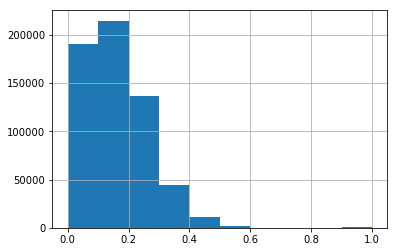

In [21]:
prox_2000.unstack().hist()

## But Wait - Problem!

at **~2 minutes** this is taking a long time to compute for one year.  This makes working with this data in an agile way problematic and computing for 50 years would take ~2 hours to compute. While this was easy to implement, it isn't very fast!

Let's **profile** this code to get an understanding where we spend most of our time

For this line to run you will need to install ``line_profiler`` by running:

```bash
conda install line_profiler
```

In [22]:
import line_profiler
%load_ext line_profiler

In [23]:
%lprun -f proximity_matrix_pandas proximity_matrix_pandas(mcp[2000])

## Step 1: Consider the Computation

Thinking about the details of the computation, the proximity matrix is symmetric because of the ``max`` condition in the denominator. Therefore we can reduce the redundant computation by computing only half of the matrix and using those values for both $i, j$ pairs.

Because product1 and product2 are string objects we will need some way of keeping track of our position when filling in the matrix values. 

This can be done using ``enumerate``

This will **half** the computation time.

In [24]:
def proximity_matrix_pandas_symmetry(mcp, fillna=True):
    products = sorted(list(mcp.columns))
    sum_products = mcp.sum(axis=0)
    proximity = pd.DataFrame(index=products, columns=products)
    for idx1, product1 in enumerate(products):
        for idx2, product2 in enumerate(products):
            if idx2 > idx1:  #Symmetric Matrix Condition
                continue
            numerator = (mcp[product1] * mcp[product2]).sum()
            denominator = max(sum_products[product1], sum_products[product2])
            if denominator == 0:
                cond_prob =  np.nan
            else:
                cond_prob = numerator / denominator
            proximity.set_value(index=product1, col=product2, value=cond_prob)
            proximity.set_value(index=product2, col=product1, value=cond_prob)
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [25]:
%%time
prox_2000_symmetry = proximity_matrix_pandas_symmetry(mcp[2000])

CPU times: user 48.7 s, sys: 632 ms, total: 49.4 s
Wall time: 48.9 s


In [26]:
#-Check if the same results as brute force method-#
prox_2000.equals(prox_2000_symmetry)

True

## Step 2: Consider other Python Tools (NumPy)

Most of the time you will want to conduct **numerical** type computing in NumPy.

The code actually looks pretty similar - the main difference is conducting operations on pure numpy arrays

In [27]:
def proximity_matrix_numpy(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    proximity = np.empty((num_products, num_products))
    col_sums = mcp.sum().values  
    data = mcp.T.as_matrix()                  #This generates a c x p numpy array
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [28]:
%%time
prox_2000_numpy = proximity_matrix_numpy(mcp[2000])

CPU times: user 1.43 s, sys: 2.49 ms, total: 1.43 s
Wall time: 1.43 s


In [29]:
prox_2000.equals(prox_2000_numpy)

True

------------------------

## Step 3: Just in Time Compilation (Numba)

**Numba** is a package you can use to accelerate your code by using a technique called **just in time (or JIT)** compilation. It converts your high-level python code to low level llvm code to run it closer to the raw machine level. 

``nopython=True`` ensures the ``jit`` compiles without any ``python`` objects. If it cannot achieve this it will throw an error.

**Numba** now supports a lot of the ``NumPy`` api and can be checked [here](http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)

In [30]:
@jit(nopython=True)
def coexport_probability(data, num_products, col_sums):
    proximity = np.empty((num_products, num_products))
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    return proximity

def proximity_matrix_numba(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    col_sums = mcp.sum().values  
    data = mcp.T.as_matrix()                  
    proximity = coexport_probability(data, num_products, col_sums)   #Call Jit Function
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [31]:
prox_2000_numba = proximity_matrix_numba(mcp[2000])

In [32]:
%%timeit
prox_2000_numba = proximity_matrix_numba(mcp[2000])

10 loops, best of 3: 146 ms per loop


In [33]:
prox_2000_numba.equals(prox_2000)

True

### Computing All Years

In [34]:
%%time
proximity = {}
for year in mcp.keys():
    proximity[year] = proximity_matrix_numba(mcp[year])

CPU times: user 7.07 s, sys: 114 ms, total: 7.18 s
Wall time: 7.21 s


In [35]:
proximity[2000].head()

productcode2      0011      0012      0013      0014      0015     0111  \
productcode1                                                              
0011          1.000000  0.448276  0.206897  0.206897  0.275862  0.37500   
0012          0.448276  1.000000  0.178571  0.107143  0.321429  0.25000   
0013          0.206897  0.178571  1.000000  0.227273  0.100000  0.12500   
0014          0.206897  0.107143  0.227273  1.000000  0.181818  0.15625   
0015          0.275862  0.321429  0.100000  0.181818  1.000000  0.28125   

productcode2      0112      0113      0114      0115  ...        8994  \
productcode1                                          ...               
0011          0.275862  0.344828  0.206897  0.241379  ...    0.068966   
0012          0.392857  0.142857  0.178571  0.142857  ...    0.035714   
0013          0.083333  0.500000  0.312500  0.153846  ...    0.153846   
0014          0.125000  0.318182  0.363636  0.090909  ...    0.090909   
0015          0.250000  0.150000  0.200000  0.250000  ...    0.050000   

productcode2      8996      8997      8998      8999      9310      9410  \
productcode1                                                               
0011          0.137931  0.162791  0.068966  0.034483  0.244898  0.178082   
0012          0.178571  0.116279  0.071429  0.000000  0.163265  0.219178   
0013          0.210526  0.093023  0.080000  0.142857  0.163265  0.095890   
0014          0.181818  0.139535  0.120000  0.045455  0.142857  0.178082   
0015          0.350000  0.139535  0.040000  0.050000  0.122449  0.150685   

productcode2      9510      9610   9710  
productcode1                             
0011          0.206897  0.137931  0.175  
0012          0.071429  0.107143  0.125  
0013          0.090909  0.071429  0.075  
0014          0.409091  0.045455  0.200  
0015          0.136364  0.150000  0.125  

[5 rows x 775 columns]

--------------------

## Using Dask to Compute all Years in Parallel

Now that we have a fast single year computation, we can compute all cross-sections serially using a loop.

Alternatively, we can parallelize these operations using ``Dask`` to delay computation and then ask the ``Dask`` scheduler to coordinate the computation over the number of **cores** available to you. This is particularly useful when using ``HS`` data. 

**Note:** This simple approach to parallelization does have some overhead to coordinate the computations so you won't get a full 4 x speed up when using a 4-core machine. 

In [36]:
import dask
from distributed import Client
Client()

<Client: scheduler='tcp://127.0.0.1:62614' processes=8 cores=8>

In [37]:
#-Setup the Computations as a Collection of Tasks-#
collection = []
for year in sorted(mcp.keys()):
    collection.append((year, dask.delayed(proximity_matrix_numba)(mcp[year])))

In [38]:
%%time
#-Compute the Results-#
result = dask.compute(*collection)

CPU times: user 1.27 s, sys: 1.46 s, total: 2.74 s
Wall time: 6.87 s


In [39]:
#-Organise the list of returned tuples into a convenient dictionary-#
results = {}
for year, df in result:
    results[year] = df

In [40]:
results[2000].equals(prox_2000)

True

In [41]:
results[2000].head()

productcode2      0011      0012      0013      0014      0015     0111  \
productcode1                                                              
0011          1.000000  0.448276  0.206897  0.206897  0.275862  0.37500   
0012          0.448276  1.000000  0.178571  0.107143  0.321429  0.25000   
0013          0.206897  0.178571  1.000000  0.227273  0.100000  0.12500   
0014          0.206897  0.107143  0.227273  1.000000  0.181818  0.15625   
0015          0.275862  0.321429  0.100000  0.181818  1.000000  0.28125   

productcode2      0112      0113      0114      0115  ...        8994  \
productcode1                                          ...               
0011          0.275862  0.344828  0.206897  0.241379  ...    0.068966   
0012          0.392857  0.142857  0.178571  0.142857  ...    0.035714   
0013          0.083333  0.500000  0.312500  0.153846  ...    0.153846   
0014          0.125000  0.318182  0.363636  0.090909  ...    0.090909   
0015          0.250000  0.150000  0.200000  0.250000  ...    0.050000   

productcode2      8996      8997      8998      8999      9310      9410  \
productcode1                                                               
0011          0.137931  0.162791  0.068966  0.034483  0.244898  0.178082   
0012          0.178571  0.116279  0.071429  0.000000  0.163265  0.219178   
0013          0.210526  0.093023  0.080000  0.142857  0.163265  0.095890   
0014          0.181818  0.139535  0.120000  0.045455  0.142857  0.178082   
0015          0.350000  0.139535  0.040000  0.050000  0.122449  0.150685   

productcode2      9510      9610   9710  
productcode1                             
0011          0.206897  0.137931  0.175  
0012          0.071429  0.107143  0.125  
0013          0.090909  0.071429  0.075  
0014          0.409091  0.045455  0.200  
0015          0.136364  0.150000  0.125  

[5 rows x 775 columns]

**Note:** [Dask](https://github.com/dask/dask) does a lot more than this and is worth looking into for medium to large scale computations

In [42]:
#-Save Results into a HDF5 File-#
fl = "data/sitcr2l4_proximity.h5"
store = pd.HDFStore(fl, mode='w')
for year in results.keys():
    store["Y{}".format(year)] = results[year]

In [43]:
store.close()

In [44]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

--------------------------

## Performance Comparison (SITC and HS Data)

For **SITC** Data: (786 Products, 229 Countries, 52 Years)


| Function         | Time/Year        | Total Time  | Speedup |
|------------------|------------------|-------------|---------|
| pandas           | 220 seconds      | ~177 minutes| -       |
| pandas_symmetric | 104 seconds      | ~84 minutes | BASE       |
| numpy            | 2.5 seconds      | 120 seconds | ~41x    |
| numba            | 124 milliseconds | 6 seconds   | ~800x   |
| numba + dask     | N/A              | 5 seconds   | -       |



For **HS** Data: (5016 Products, 222 Countries, 20 Years)

| Function         | Time/Year                    | Total Time | Speedup |
|------------------|------------------------------|------------|---------|
| pandas           | 1 Hour 25 minutes |      -     | -       |
| pandas_symmetric | 43 minutes                   |      -     | BASE       |
| numpy            | 1 min 37 seconds             |      -     | ~28x    |
| numba            | 5 seconds                    | 1min 45 seconds   | ~516x   |
| numba + dask     | N/A                          | 45 seconds      |    -     |

These were run on the following **machine:**

| Item      | Details          |
|-----------|------------------|
| Processor | Xeon E5 @ 3.6Ghz |
| Cores     | 8                |
| RAM       | 32Gb RAM         |
| Python    | Python 3.6       |

------------------_

## (Extension) Preparing Graph Data: Product Space Network

Here we will use ``NetworkX`` to construct our version of the Product Space using Python

In [45]:
prox = pd.read_hdf("data/sitcr2l4_proximity.h5", key="Y2000")

In [46]:
prox.head()

productcode2      0011      0012      0013      0014      0015     0111  \
productcode1                                                              
0011          1.000000  0.448276  0.206897  0.206897  0.275862  0.37500   
0012          0.448276  1.000000  0.178571  0.107143  0.321429  0.25000   
0013          0.206897  0.178571  1.000000  0.227273  0.100000  0.12500   
0014          0.206897  0.107143  0.227273  1.000000  0.181818  0.15625   
0015          0.275862  0.321429  0.100000  0.181818  1.000000  0.28125   

productcode2      0112      0113      0114      0115  ...        8994  \
productcode1                                          ...               
0011          0.275862  0.344828  0.206897  0.241379  ...    0.068966   
0012          0.392857  0.142857  0.178571  0.142857  ...    0.035714   
0013          0.083333  0.500000  0.312500  0.153846  ...    0.153846   
0014          0.125000  0.318182  0.363636  0.090909  ...    0.090909   
0015          0.250000  0.150000  0.200000  0.250000  ...    0.050000   

productcode2      8996      8997      8998      8999      9310      9410  \
productcode1                                                               
0011          0.137931  0.162791  0.068966  0.034483  0.244898  0.178082   
0012          0.178571  0.116279  0.071429  0.000000  0.163265  0.219178   
0013          0.210526  0.093023  0.080000  0.142857  0.163265  0.095890   
0014          0.181818  0.139535  0.120000  0.045455  0.142857  0.178082   
0015          0.350000  0.139535  0.040000  0.050000  0.122449  0.150685   

productcode2      9510      9610   9710  
productcode1                             
0011          0.206897  0.137931  0.175  
0012          0.071429  0.107143  0.125  
0013          0.090909  0.071429  0.075  
0014          0.409091  0.045455  0.200  
0015          0.136364  0.150000  0.125  

[5 rows x 775 columns]

#### use pandas to construct and edge list

In [47]:
edge_list = prox.unstack()

In [48]:
#-Construct Sequence of node pairs as a pd.Series
edge_list.head()

productcode2  productcode1
0011          0011            1.000000
              0012            0.448276
              0013            0.206897
              0014            0.206897
              0015            0.275862
dtype: float64

In [49]:
#-Remove Self Loops-#
edge_list = edge_list[edge_list != 1.0]     #TODO: do this operation properly to compare node1 == node2

In [50]:
edge_list.head()

productcode2  productcode1
0011          0012            0.448276
              0013            0.206897
              0014            0.206897
              0015            0.275862
              0111            0.375000
dtype: float64

#### We would like to construct the maximum_spanning_tree, but the current version of networkx supports minimum_spanning_tree so we need to add inv_weight for this computation. 

In [51]:
#-Construct DataFrame-#
edge_list = edge_list.reset_index()
edge_list.columns = ["P1","P2","weight"]

In [52]:
edge_list["inv_weight"] = 1 - edge_list['weight']    #Useful when working with minimum spanning tree in networkx

In [53]:
edge_list.head()

P1    P2    weight  inv_weight
0  0011  0012  0.448276    0.551724
1  0011  0013  0.206897    0.793103
2  0011  0014  0.206897    0.793103
3  0011  0015  0.275862    0.724138
4  0011  0111  0.375000    0.625000

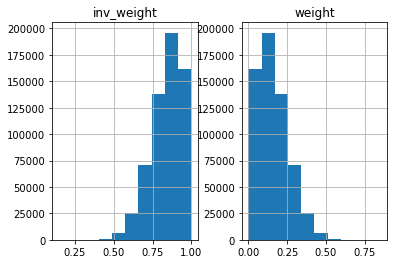

In [54]:
edge_list[["weight","inv_weight"]].hist();

# Network Tools

We want to now construct a maximum_spanning_tree and then add in all nodes that are highly connected above a threshold value of ``0.5``

In [55]:
import networkx as nx

In [56]:
#-Construct the complete network-#
g = nx.from_pandas_dataframe(edge_list, source="P1", target="P2", edge_attr=["weight", "inv_weight"])
print("# of Nodes: {}".format(g.number_of_nodes()))
print("# of Edges: {}".format(g.number_of_edges()))

# of Nodes: 775
# of Edges: 299925


In [57]:
mst = nx.minimum_spanning_tree(g, weight='inv_weight') #Maximum Spanning Tree
print("# of Nodes: {}".format(mst.number_of_nodes()))
print("# of Edges: {}".format(mst.number_of_edges()))

# of Nodes: 775
# of Edges: 774


In [58]:
mst["0011"]

{'0012': {'inv_weight': 0.5517241379310345, 'weight': 0.4482758620689655},
 '0223': {'inv_weight': 0.5517241379310345, 'weight': 0.4482758620689655}}

In [59]:
#-Build Maximum Spanning Tree + Keep Edges > 0.50-#
ps = nx.Graph()
#Add MST ('weight' attribute only)
for u,v,w in mst.edges_iter(data=True):
    ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})
#Add Edges > 0.50
for u,v,w in g.edges_iter(data=True):
    if w['weight'] >= 0.50:
        ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})

In [60]:
print("# of Nodes: {}".format(ps.number_of_nodes()))
print("# of Edges: {}".format(ps.number_of_edges()))

# of Nodes: 775
# of Edges: 1547


## Visualizations

In [61]:
ps_nodes = pd.read_csv("data/PS_SITC_nodes", sep="\t", converters={'sitc' : str},
                       names=["sitc", "community", "x", "y", "nodesize","leamer","pname","ncolor"])
ps_edges = pd.read_csv("data/PS_SITC_edges", sep="\t", converters={'sourceid' : str, 'targetid' : str},
                       names=["sourceid", "sourcex", "sourcey","targetid","targetx","targety", "width","color"])

In [62]:
ps_nodes.head()

sitc  community            x            y   nodesize  leamer  \
0  6932        999  4551.899658  2540.087158  48.780762       8   
1  7362         10   216.835098  5013.330811  65.180725       9   
2  7911         10   538.914902  5650.589111  53.997589       9   
3  8946         10   696.394257  5316.897949  57.695251       7   
4  7264         10    57.284065  5879.528076  73.333267       9   

                                            pname   ncolor  
0  WIRE,TWISTED HOOP FOR FENCING OF IRON OR STEEL  #9c9a87  
1                     METAL FORMING MACHINE TOOLS  #4037ab  
2                       RAIL LOCOMOTIVES,ELECTRIC  #4037ab  
3       NON-MILITARY ARMS AND AMMUNITION THEREFOR  #4037ab  
4                                PRINTING PRESSES  #4037ab

In [63]:
ps_nodes.shape

(774, 8)

In [64]:
def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df[column+"_scaled"] = (df[column] - min_value) / (max_value - min_value)
    return df

In [65]:
#Preprocess Coordinates to be Normalized between 0,1
ps_nodes = normalize(ps_nodes, 'x')
ps_nodes = normalize(ps_nodes, 'y')

In [66]:
ps_nodes.head()

sitc  community            x            y   nodesize  leamer  \
0  6932        999  4551.899658  2540.087158  48.780762       8   
1  7362         10   216.835098  5013.330811  65.180725       9   
2  7911         10   538.914902  5650.589111  53.997589       9   
3  8946         10   696.394257  5316.897949  57.695251       7   
4  7264         10    57.284065  5879.528076  73.333267       9   

                                            pname   ncolor  x_scaled  y_scaled  
0  WIRE,TWISTED HOOP FOR FENCING OF IRON OR STEEL  #9c9a87  0.831500  0.136279  
1                     METAL FORMING MACHINE TOOLS  #4037ab  0.335160  0.632872  
2                       RAIL LOCOMOTIVES,ELECTRIC  #4037ab  0.372036  0.760825  
3       NON-MILITARY ARMS AND AMMUNITION THEREFOR  #4037ab  0.390066  0.693824  
4                                PRINTING PRESSES  #4037ab  0.316892  0.806793

In [67]:
import numpy as np
#-Obtain Dictionary of Coordinates-#
coord = {}
xy = ps_nodes[["x_scaled","y_scaled"]].values
for idx, productcode in enumerate(ps_nodes["sitc"]):
   coord[productcode] = xy[idx]
#-Add Missing Nodes-#
coord['6784'] = np.array([0,0])

In [68]:
coord

{'0011': array([ 0.63635789,  0.29305675]),
 '0012': array([ 0.89501582,  0.00749056]),
 '0013': array([ 0.49858259,  0.76763095]),
 '0014': array([ 0.5520262 ,  0.40525301]),
 '0015': array([ 0.74470858,  0.71973192]),
 '0111': array([ 0.79874644,  0.84198768]),
 '0112': array([ 0.87884575,  0.01180109]),
 '0113': array([ 0.49590829,  0.67857286]),
 '0114': array([ 0.48507251,  0.76832806]),
 '0115': array([ 0.76640784,  0.76481862]),
 '0116': array([ 0.81179179,  0.81664421]),
 '0118': array([ 0.64906381,  0.19757255]),
 '0121': array([ 0.10098441,  0.53733217]),
 '0129': array([ 0.68994095,  0.30165181]),
 '0141': array([ 0.52012477,  0.78594745]),
 '0142': array([ 0.68846539,  0.38211879]),
 '0149': array([ 0.66141205,  0.31634175]),
 '0223': array([ 0.65156137,  0.37792959]),
 '0224': array([ 0.68550201,  0.40946486]),
 '0230': array([ 0.71059287,  0.6434541 ]),
 '0240': array([ 0.70160323,  0.42749238]),
 '0251': array([ 0.71759312,  0.38431479]),
 '0252': array([ 0.4006868 ,  0.

In [69]:
#-Check Entry-#
ps_nodes[ps_nodes.sitc == "0011"]

sitc  community            x           y   nodesize  leamer  \
491  0011        239  2847.516846  3320.90686  60.540527       5   

                                                 pname   ncolor  x_scaled  \
491  ANIMALS OF THE BOVINE SPECIES,INCL.BUFFALOES,LIVE  #9fb3bf  0.636358   

     y_scaled  
491  0.293057

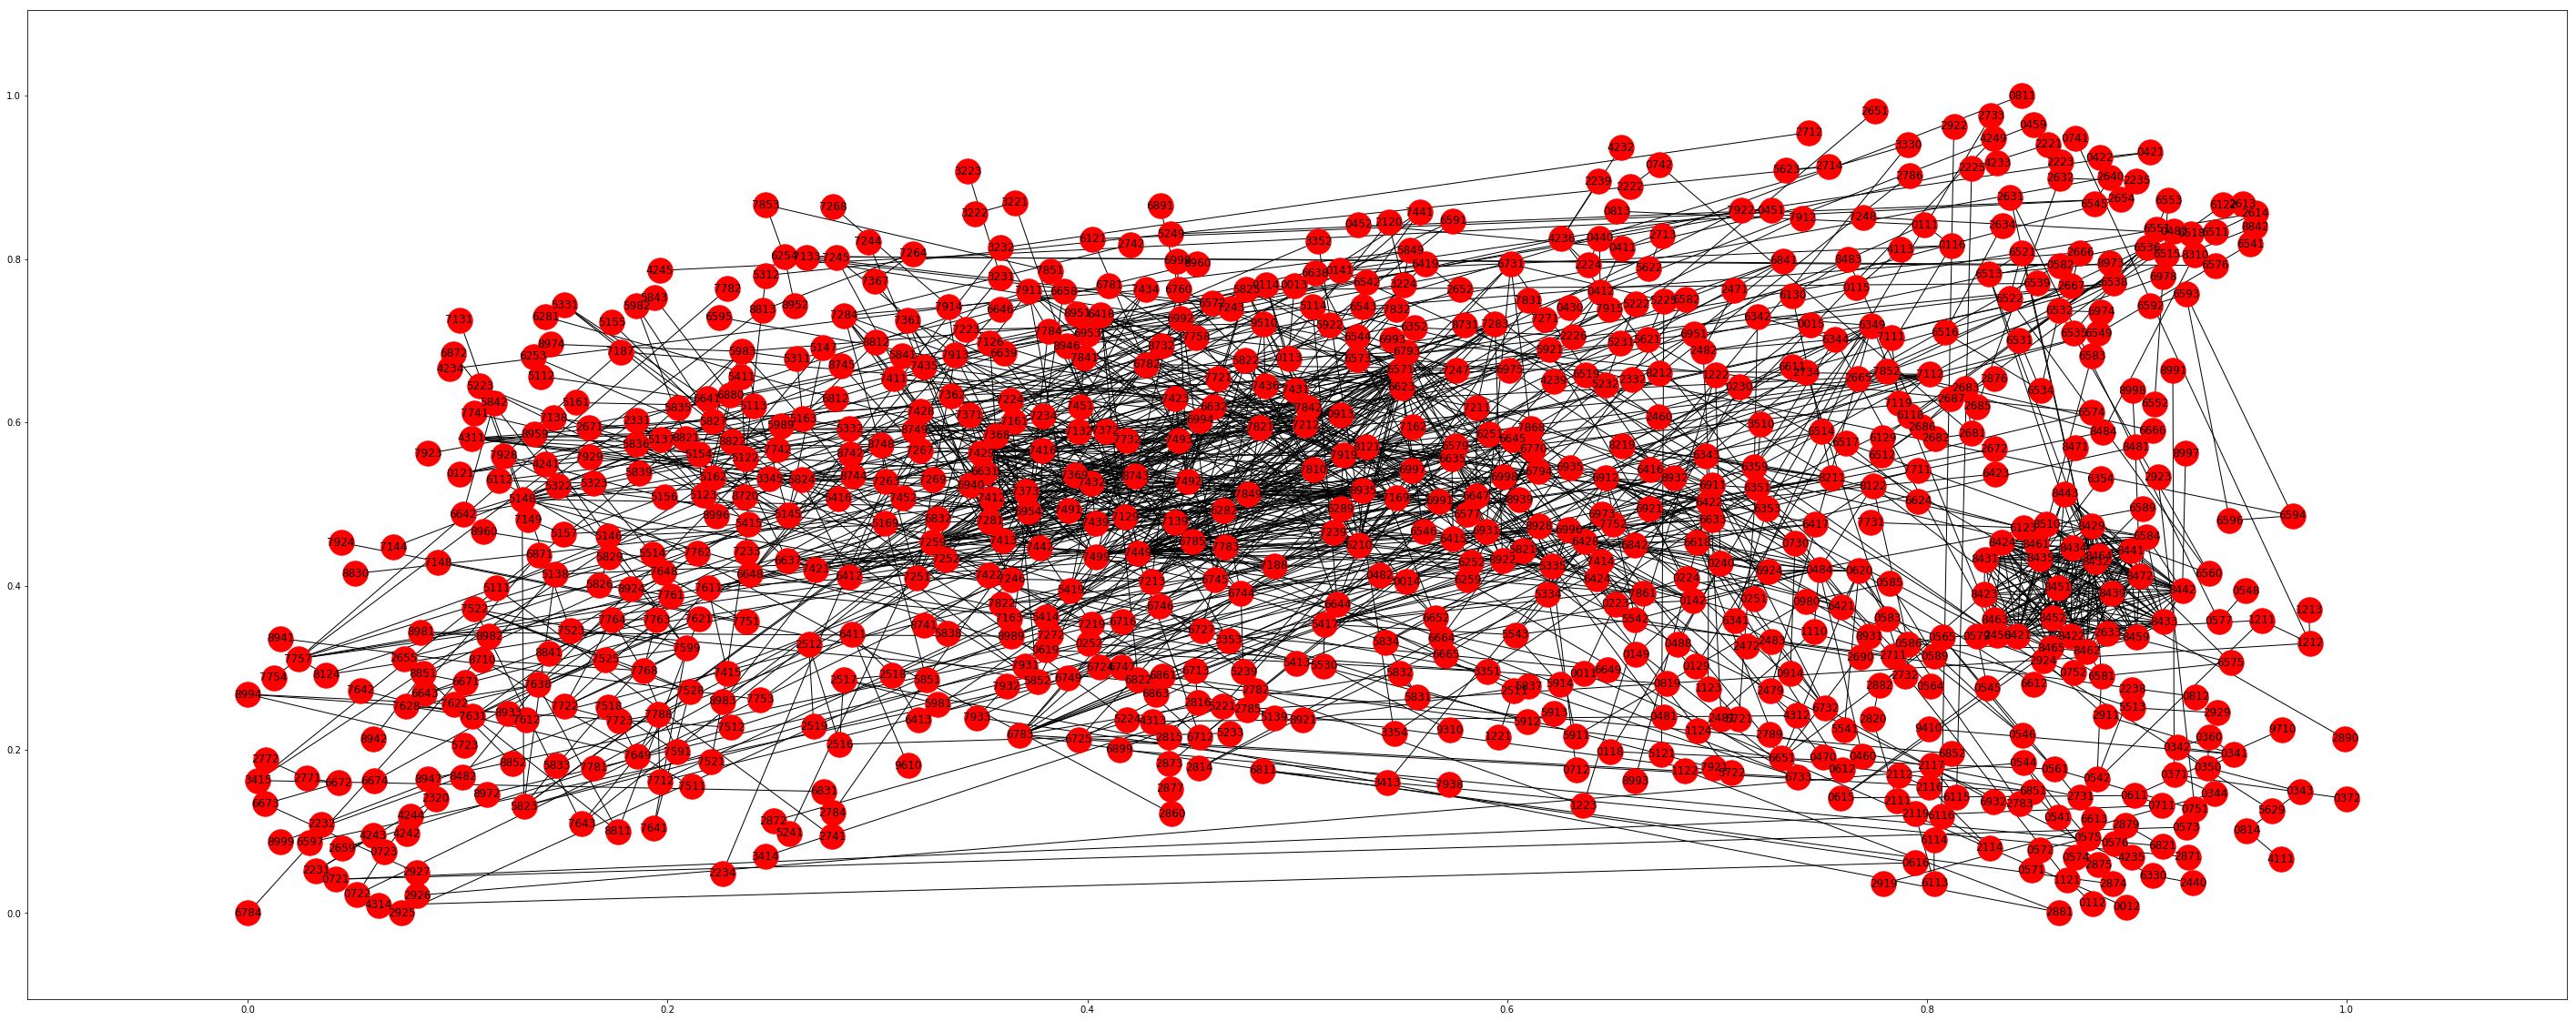

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(ps, ax=ax, pos=coord, node_size=750, width=1)
plt.savefig("productspace1.png")

**Note:** File is saved Locally to view the network in greater detail

In [71]:
#-Let's See where Apparel Chapter 84 Nodes are Located-#
def choose_color(x):
    if x[:2] == "84":
        return "b"
    else:
        return "r"
    
nodes = pd.DataFrame(sorted(list(coord.keys())), columns=["nodeid"])
nodes["color"] = nodes["nodeid"].apply(lambda x: choose_color(x))

In [72]:
nodes[nodes.color == 'b'].head()

nodeid color
689   8421     b
690   8422     b
691   8423     b
692   8424     b
693   8429     b

In [73]:
#-Get the Order of Nodes the Same as Network Node List
order = pd.DataFrame(ps.nodes()).reset_index()
order.columns = ["order", "nodeid"]
nodes = nodes.merge(order, how="inner", on="nodeid")
nodes = nodes.sort_values(by="order")

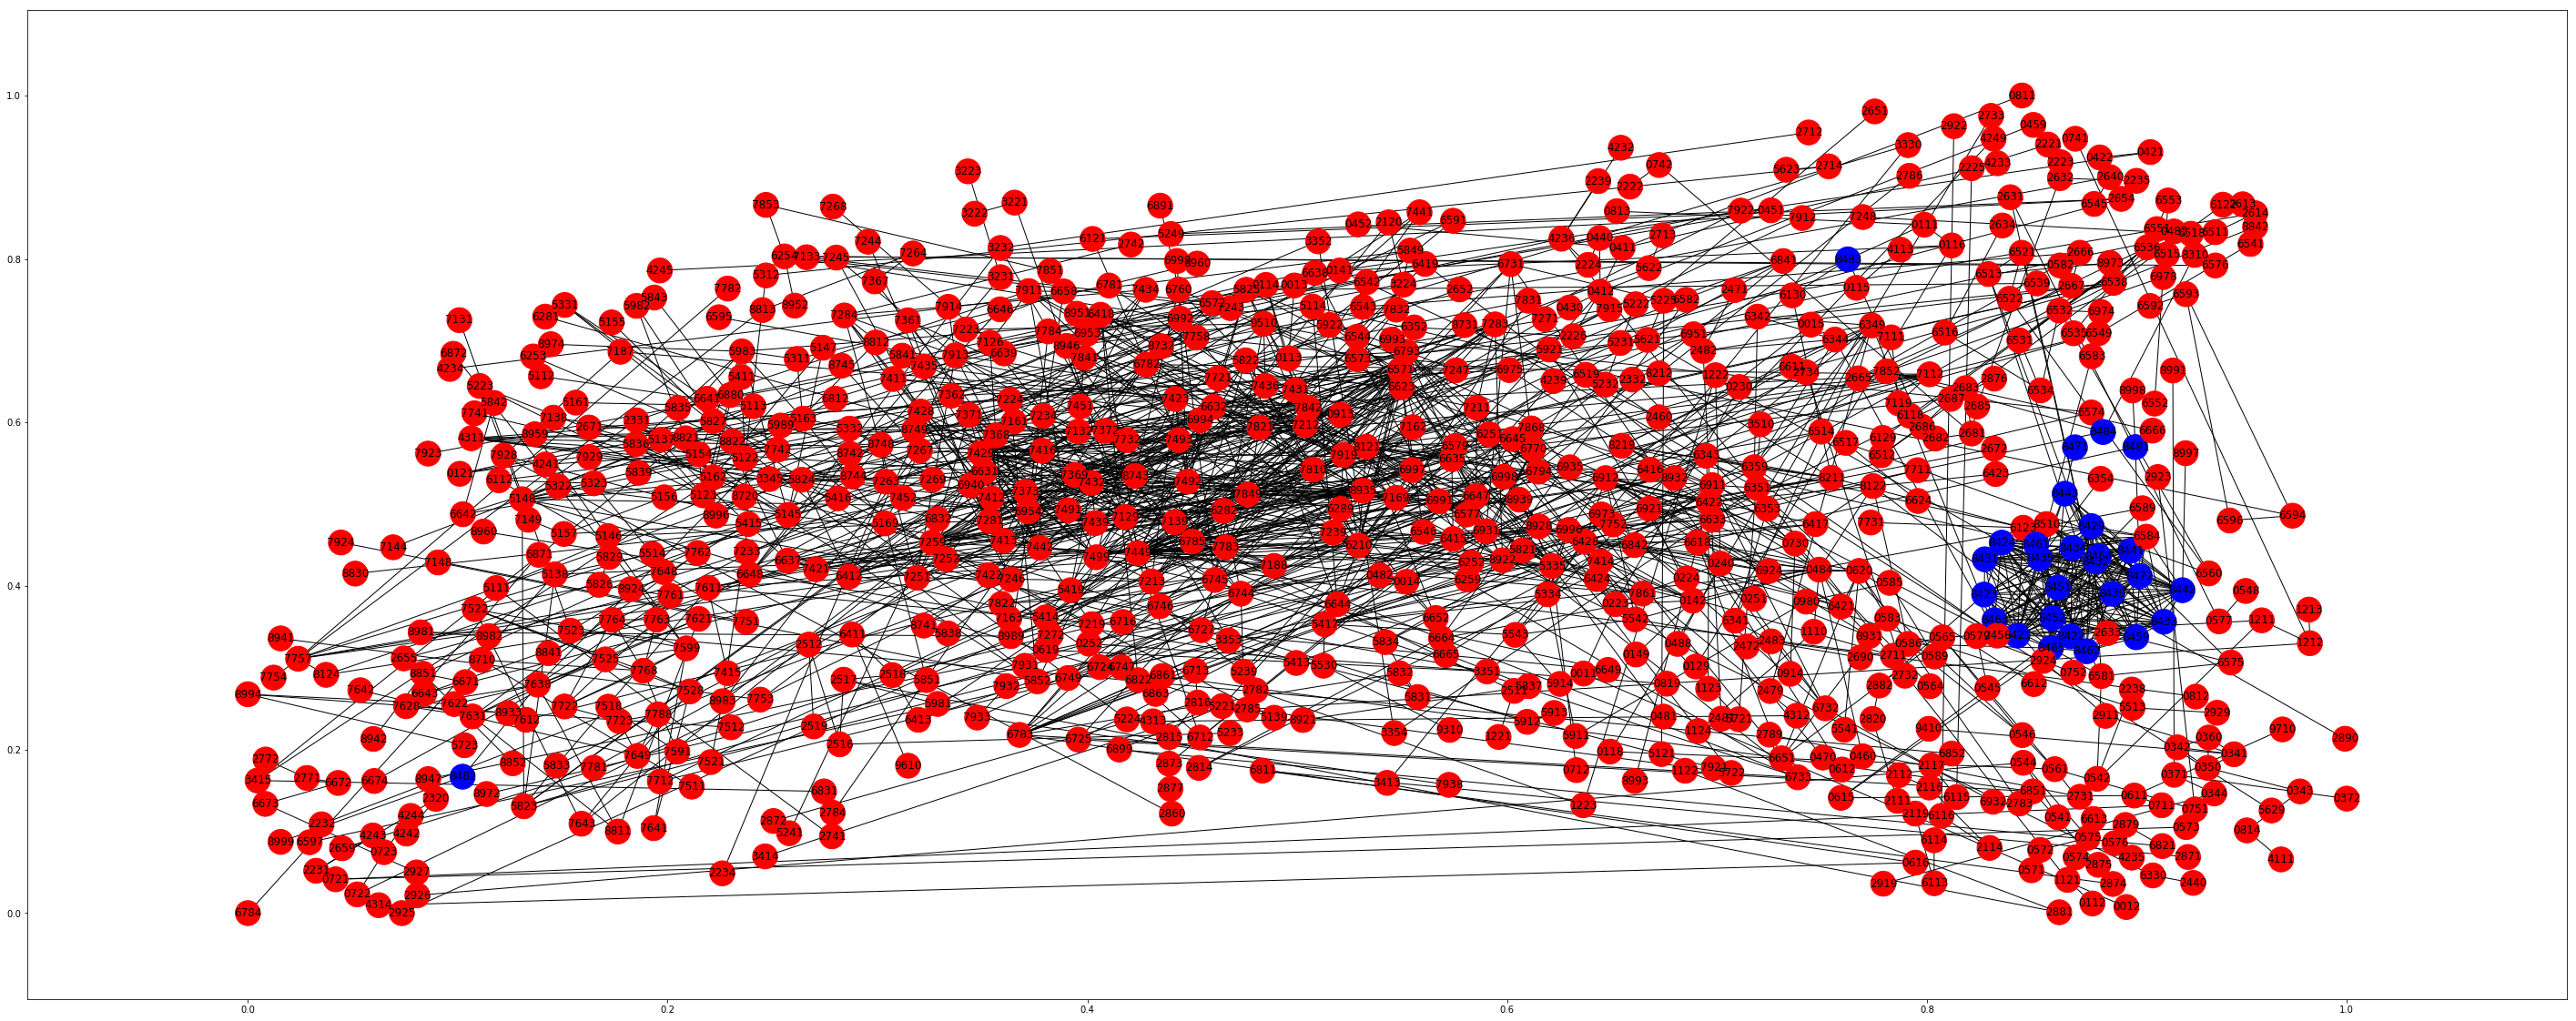

In [74]:
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(ps, ax=ax, pos=coord, node_size=750, width=1, node_color = nodes.color.values, )
plt.savefig("productspace2.png")

In [75]:
#Can Output to use with Gephi / Cytoscape (Exploratory Network Tools)
nx.write_gml(ps, "prouduct_space.gml")   

# References

[1] Hidalgo, C.A., Klinger, B., Barabasi, A.-L., Hausmann, R. (2007), "The Product Space Conditions the Development of Nations", Science, Vol 317, pp 482-487

[2] Atlas of Complexity (http://atlas.cid.harvard.edu/)

[3] The Observatory of Economic Complexity (http://atlas.media.mit.edu/en/)

[4] Atlas of Complexity Gride Points for Nodes sourced from http://www.michelecoscia.com/?page_id=223

[5] Balassa, B. (1965), "Trade Liberalisation and Revealed Comparative Advantage", The Manchester School, 33, 99-123.